#Set Up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import random

epsilons = [0, .05, .1, .15, .20]

In [2]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [-1,1] range
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    # Return the perturbed image
    return perturbed_image

def ifgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [-1,1] range
    perturbed_image = torch.clamp(perturbed_image, image-epsilon, image+epsilon)
    # Return the perturbed image
    return perturbed_image

In [3]:
def test(model, device, test_loader, epsilon, count):
    # Accuracy counter
    correct_FGSM = 0
    correct_IFGSM = 0    

    example = []

    # Loop over all examples in test set
    for data, target in test_loader:
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        data = data.requires_grad_() 
        output = model(data)        
        data_IFGSM = data
        output_IFGSM = output
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if init_pred.item() != target.item():
            continue
        
        #FGSM
        # Calculate the loss
        loss = F.nll_loss(output, target)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect datagrad
        data_grad = data.grad.data        
        # Call FGSM Attack
        perturbed_FGSM_data = fgsm_attack(data, epsilon, data_grad)     
        # Re-classify the perturbed image
        output_FGSM = model(perturbed_FGSM_data)
        final_FGSM = output_FGSM.max(1, keepdim=True)[1] # get the index of the max log-probability        

        #IFGSM
        for i in range(count):                
          if i != 0:   
            # Calculate the loss
            loss = F.nll_loss(output_IFGSM, target)          
            # Zero all existing gradients
            model.zero_grad()
            # Calculate gradients of model in backward pass
            loss.backward()
            # Collect datagrad
            data_grad = data_IFGSM.grad.data
          # Call FGSM Attack
          perturbed_IFGSM_data = ifgsm_attack(data_IFGSM, epsilon/count, data_grad)          
          # Set adversarial example to the input of re-create
          data_IFGSM = perturbed_IFGSM_data.clone().detach().requires_grad_(True)
          # Set requires_grad attribute of tensor. Important for Attack          
          output_IFGSM = model(data_IFGSM)      
          #print(output)
          if epsilon == 0:
            break
        # Check for success
        final_IFGSM = output_IFGSM.max(1, keepdim=True)[1] # get the index of the max log-probability

        if final_FGSM.item() == target.item():
            correct_FGSM = correct_FGSM+1

        if final_IFGSM.item() == target.item():
            correct_IFGSM = correct_IFGSM+1     

        if epsilon != 0 and final_FGSM.item() != target.item():
            example.append((data, target))                           

    # Calculate final accuracy for this epsilon    
    final_FGSM_acc = correct_FGSM/len(test_loader)
    print("Epsilon: {}\tFGSM  Accuracy = {} / {} = {}".format(epsilon, correct_FGSM, len(test_loader), final_FGSM_acc))
    final_IFGSM_acc = correct_IFGSM/len(test_loader)
    print("           \tIFGSM Accuracy = {} / {} = {}".format(correct_IFGSM, len(test_loader), final_IFGSM_acc))

    return final_FGSM_acc, final_IFGSM_acc, example

In [4]:
def test_example( model, device, data, target, epsilon, count):
  # Send the data and label to the device
  data, target = data.to(device), target.to(device)
  data = data.requires_grad_() 
  output = model(data)  
  data_IFGSM = data
  output_IFGSM = output
  init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
  
  #FGSM
  loss = F.nll_loss(output, target)
  model.zero_grad()
  loss.backward()
  data_grad = data.grad.data        
  perturbed_FGSM_data = fgsm_attack(data, epsilon, data_grad)     
  output_FGSM = model(perturbed_FGSM_data)
  final_FGSM = output_FGSM.max(1, keepdim=True)[1] # get the index of the max log-probability
  ex_F = perturbed_FGSM_data.squeeze().detach().cpu().numpy()
  ex_F = (ex_F, final_FGSM)

  for i in range(count):                
    if i != 0:   
      loss = F.nll_loss(output_IFGSM, target)          
      model.zero_grad()
      loss.backward()
      data_grad = data_IFGSM.grad.data
    perturbed_IFGSM_data = ifgsm_attack(data_IFGSM, epsilon/count, data_grad)          
    data_IFGSM = perturbed_IFGSM_data.clone().detach().requires_grad_(True)
    output_IFGSM = model(data_IFGSM)      
    if epsilon == 0:
      break      
  final_IFGSM = output_IFGSM.max(1, keepdim=True)[1] # get the index of the max log-probability
  ex_I = perturbed_IFGSM_data.squeeze().detach().cpu().numpy()
  ex_I = (ex_I, final_IFGSM)  

  return  init_pred, ex_F, ex_I

#Mnist

In [10]:
pretrained_model = "data/lenet_mnist_model.pth"

In [11]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [12]:
# MNIST Test dataset and dataloader declaration
test_set = datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),]))
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size=1, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [14]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  False


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

Mnist FGSM-IFGSM

In [ ]:
accuracies_FGSM = []
accuracies_IFGSM = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc_F, acc_I, ex = test(model, device, test_loader, eps, 5)    
    if len(examples) == 0:
      examples = ex       
    accuracies_FGSM.append(acc_F)    
    accuracies_IFGSM.append(acc_I)    

Epsilon: 0	FGSM  Accuracy = 9810 / 10000 = 0.981
           	IFGSM Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	FGSM  Accuracy = 9151 / 10000 = 0.9151
           	IFGSM Accuracy = 8866 / 10000 = 0.8866
Epsilon: 0.1	FGSM  Accuracy = 7539 / 10000 = 0.7539
           	IFGSM Accuracy = 5972 / 10000 = 0.5972
Epsilon: 0.15	FGSM  Accuracy = 4837 / 10000 = 0.4837
           	IFGSM Accuracy = 2118 / 10000 = 0.2118
Epsilon: 0.2	FGSM  Accuracy = 2285 / 10000 = 0.2285
           	IFGSM Accuracy = 428 / 10000 = 0.0428


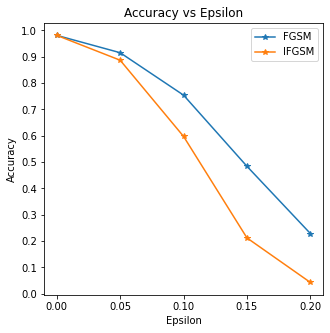

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_FGSM, "*-", label = "FGSM")
plt.plot(epsilons, accuracies_IFGSM, "*-", label = "IFGSM")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, float(epsilons[len(epsilons)-1])+0.03, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
sample_size = 3
sample = random.sample(examples, sample_size)
ex = []
init = []

for i in range(len(epsilons)):
  for j in range(sample_size):
    ini, ex_F, ex_I = test_example(model, device, sample[j][0], sample[j][1], epsilons[i], 5)
    init.append(ini)
    ex.append(ex_F)
    ex.append(ex_I)    

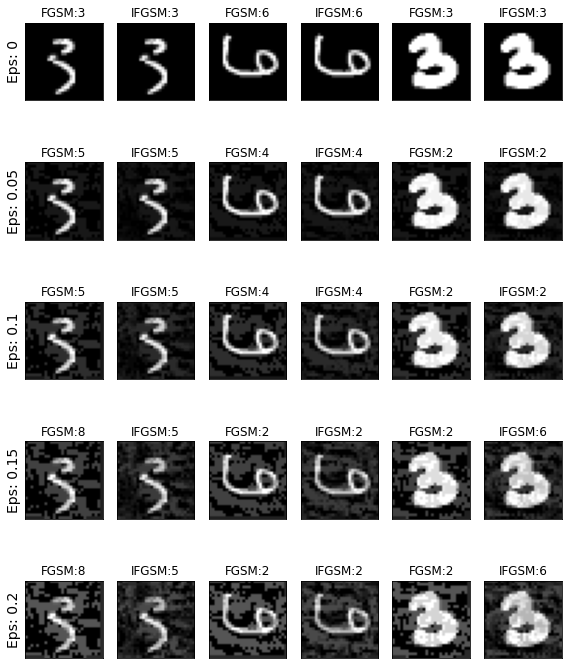

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(6):
        cnt += 1
        plt.subplot(len(epsilons), sample_size*2, cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        exs, final = ex[j+(i*6)]
        plt.imshow(exs, cmap="gray")
        plt.title("FGSM:{}".format(final.item()) if j %2 == 0 else ("IFGSM:{}".format(final.item())))
plt.tight_layout()    
plt.show()

#Fashion Mnist

In [23]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('MNIST/raw/train-images-idx3-ubyte', train=True, download=True, transform=transforms.Compose([
            transforms.Resize([28, 28]), transforms.ToTensor(),
            ])),
            batch_size=100, shuffle=True)

In [24]:
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('FashionMNIST/raw/t10k-images-idx3-ubyte', train=False, download=True, transform=transforms.Compose([
            transforms.Resize([28, 28]), transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [39]:
#PANKAJ's Model https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy/notebook
class FashionCNN(nn.Module):    
    def __init__(self):
        super(FashionCNN, self).__init__()        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=10)        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)       
        
        return out

In [40]:
# Initialize the network
model_F = FashionCNN().to(device)
optimizer = torch.optim.Adam(model_F.parameters(), lr=0.001)

error = nn.CrossEntropyLoss()

model_F.eval()

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=10, bias=True)
)

In [41]:
num_epochs = 8

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model_F(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()

In [31]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

Fashion Mnist FGSM

In [42]:
accuracies_FGSM = []
accuracies_IFGSM = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc_F, acc_I, ex = test(model_F, device, test_loader, eps, 5)    
    if len(examples) == 0:
      examples = ex       
    accuracies_FGSM.append(acc_F)    
    accuracies_IFGSM.append(acc_I)

Epsilon: 0	FGSM  Accuracy = 9084 / 10000 = 0.9084
           	IFGSM Accuracy = 9084 / 10000 = 0.9084
Epsilon: 0.05	FGSM  Accuracy = 1516 / 10000 = 0.1516
           	IFGSM Accuracy = 117 / 10000 = 0.0117
Epsilon: 0.1	FGSM  Accuracy = 87 / 10000 = 0.0087
           	IFGSM Accuracy = 0 / 10000 = 0.0
Epsilon: 0.15	FGSM  Accuracy = 22 / 10000 = 0.0022
           	IFGSM Accuracy = 0 / 10000 = 0.0
Epsilon: 0.2	FGSM  Accuracy = 24 / 10000 = 0.0024
           	IFGSM Accuracy = 0 / 10000 = 0.0


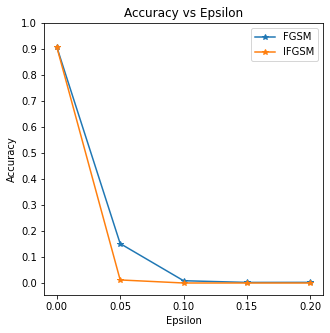

In [43]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_FGSM, "*-", label = "FGSM")
plt.plot(epsilons, accuracies_IFGSM, "*-", label = "IFGSM")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, float(epsilons[len(epsilons)-1])+0.03, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [44]:
sample_size = 3
sample = random.sample(examples, sample_size)
ex = []
init = []

for i in range(len(epsilons)):
  for j in range(sample_size):
    ini, ex_F, ex_I = test_example(model_F, device, sample[j][0], sample[j][1], epsilons[i], 5)
    init.append(ini)
    ex.append(ex_F)
    ex.append(ex_I)    

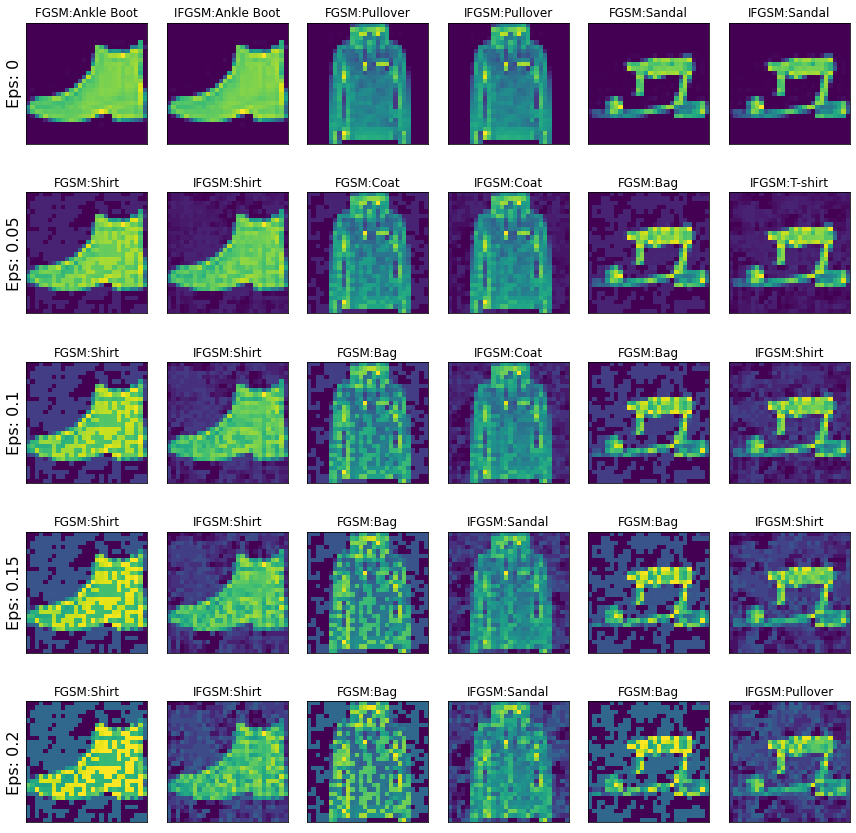

In [45]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(12,12))
for i in range(len(epsilons)):
    for j in range(6):
        cnt += 1
        plt.subplot(len(epsilons), sample_size*2, cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=16)
        exs, final = ex[j+(i*6)]
        plt.imshow(exs)        
        plt.title("FGSM:{}".format(output_label(final.item())) if j %2 == 0 else ("IFGSM:{}".format(output_label(final.item()))))
plt.tight_layout()    
plt.show()